# Policing Equity

![Policing Equity](https://gelaw.co.za/wp-content/uploads/law-wallpapers-hd-1080p-1920x1080-desktop-02.jpg)

# Notebook Imports

In [1]:
!pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 9.6 MB/s eta 0:00:00


In [2]:
!pip install scikit-learn

In [3]:
import os
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
from scipy import stats
from umap import UMAP
import re

import matplotlib.pyplot as plt
import warnings
from prince import MCA
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.manifold import TSNE

warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

# Constants

In [4]:
FILE = '/kaggle/input/data-science-for-good/Dept_49-00035/49-00035_Incidents_2016.csv'

# Step 1: Data Exploration and Preprocessing

### Load Data

In [5]:
data = pd.read_csv(FILE, low_memory=False)
df = pd.DataFrame(data)

df.drop([0], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,CRIME_TYPE,INCIDENT_DATE,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_REASON,LOCATION_DISTRICT,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_CITY,LOCATION_STATE
0,DOMESTIC VIOLENCE,12/6/16 16:12,16-064496,THREAT CRIME:INT:TERRORIZE,04X,1700 MARTIN LUTHER KING JR W,Oakland,CA
1,STOLEN VEHICLE,12/6/16 7:20,16-064497,VEHICLE THEFT - AUTO,27X,1600 HIGH ST,Oakland,CA
2,FELONY ASSAULT,12/6/16 19:00,16-064499,OBSTRUCT/RESIST/ETC PUBLIC/PEACE OFFICER/EMERG...,08X,2800 TELEGRAPH AV,Oakland,CA
3,NARCOTICS,12/6/16 19:20,16-064501,POSSESS CONTROLLED SUBSTANCE PARAPHERNALIA,07X,34TH ST & LINDEN ST,Oakland,CA
4,DISORDERLY CONDUCT,12/6/16 18:48,16-064505,DISORDERLY CONDUCT - ALCOHOL,04X,2100 SAN PABLO AV,Oakland,CA


### Data Exploration

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10769 entries, 0 to 10768
Data columns (total 8 columns):
 #   Column                                        Non-Null Count  Dtype 
---  ------                                        --------------  ----- 
 0   CRIME_TYPE                                    10060 non-null  object
 1   INCIDENT_DATE                                 10767 non-null  object
 2   INCIDENT_UNIQUE_IDENTIFIER                    10769 non-null  object
 3   INCIDENT_REASON                               10769 non-null  object
 4   LOCATION_DISTRICT                             10572 non-null  object
 5   LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION  10769 non-null  object
 6   LOCATION_CITY                                 10769 non-null  object
 7   LOCATION_STATE                                10769 non-null  object
dtypes: object(8)
memory usage: 673.2+ KB


In [7]:
print(f"\nThe shape of the data: {df.shape}\n")
print(f"The types of the data: \n{df.dtypes}\n")
print(f"The empty row in the data: \n{df.isnull().sum()}")


The shape of the data: (10769, 8)

The types of the data: 
CRIME_TYPE                                      object
INCIDENT_DATE                                   object
INCIDENT_UNIQUE_IDENTIFIER                      object
INCIDENT_REASON                                 object
LOCATION_DISTRICT                               object
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    object
LOCATION_CITY                                   object
LOCATION_STATE                                  object
dtype: object

The empty row in the data: 
CRIME_TYPE                                      709
INCIDENT_DATE                                     2
INCIDENT_UNIQUE_IDENTIFIER                        0
INCIDENT_REASON                                   0
LOCATION_DISTRICT                               197
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION      0
LOCATION_CITY                                     0
LOCATION_STATE                                    0
dtype: int64


In [8]:
df.head()

,CRIME_TYPE,INCIDENT_DATE,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_REASON,LOCATION_DISTRICT,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_CITY,LOCATION_STATE
0,DOMESTIC VIOLENCE,12/6/16 16:12,16-064496,THREAT CRIME:INT:TERRORIZE,04X,1700 MARTIN LUTHER KING JR W,Oakland,CA
1,STOLEN VEHICLE,12/6/16 7:20,16-064497,VEHICLE THEFT - AUTO,27X,1600 HIGH ST,Oakland,CA
2,FELONY ASSAULT,12/6/16 19:00,16-064499,OBSTRUCT/RESIST/ETC PUBLIC/PEACE OFFICER/EMERG...,08X,2800 TELEGRAPH AV,Oakland,CA
3,NARCOTICS,12/6/16 19:20,16-064501,POSSESS CONTROLLED SUBSTANCE PARAPHERNALIA,07X,34TH ST & LINDEN ST,Oakland,CA
4,DISORDERLY CONDUCT,12/6/16 18:48,16-064505,DISORDERLY CONDUCT - ALCOHOL,04X,2100 SAN PABLO AV,Oakland,CA


### Data Cleaning

In [9]:
mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
mode_imputer.fit(df)
imputed_data = mode_imputer.transform(df)
df = pd.DataFrame(data=imputed_data, columns=df.columns)
df.isnull().sum()

CRIME_TYPE                                      0
INCIDENT_DATE                                   0
INCIDENT_UNIQUE_IDENTIFIER                      0
INCIDENT_REASON                                 0
LOCATION_DISTRICT                               0
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0
LOCATION_CITY                                   0
LOCATION_STATE                                  0
dtype: int64

In [10]:
df.duplicated().value_counts()

False    10768
True         1
Name: count, dtype: int64

In [11]:
df.drop_duplicates(inplace=True)

### Data Preprocessing

In [12]:
# Extracting dates

df['INCIDENT_DATE'] = pd.to_datetime(df['INCIDENT_DATE'], format="mixed")
df["INCIDENT_YEAR"] = df["INCIDENT_DATE"].dt.strftime('%Y')
df["INCIDENT_MONTH"] = df["INCIDENT_DATE"].dt.strftime('%B')
df["INCIDENT_TIME"] = df["INCIDENT_DATE"].dt.strftime("%H:%M")

df.drop(['INCIDENT_DATE'], axis=1, inplace=True)

In [13]:
df.head()

,CRIME_TYPE,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_REASON,LOCATION_DISTRICT,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_CITY,LOCATION_STATE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_TIME
0,DOMESTIC VIOLENCE,16-064496,THREAT CRIME:INT:TERRORIZE,04X,1700 MARTIN LUTHER KING JR W,Oakland,CA,2016,December,16:12
1,STOLEN VEHICLE,16-064497,VEHICLE THEFT - AUTO,27X,1600 HIGH ST,Oakland,CA,2016,December,07:20
2,FELONY ASSAULT,16-064499,OBSTRUCT/RESIST/ETC PUBLIC/PEACE OFFICER/EMERG...,08X,2800 TELEGRAPH AV,Oakland,CA,2016,December,19:00
3,NARCOTICS,16-064501,POSSESS CONTROLLED SUBSTANCE PARAPHERNALIA,07X,34TH ST & LINDEN ST,Oakland,CA,2016,December,19:20
4,DISORDERLY CONDUCT,16-064505,DISORDERLY CONDUCT - ALCOHOL,04X,2100 SAN PABLO AV,Oakland,CA,2016,December,18:48


In [14]:
df.shape

(10768, 10)

In [15]:
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(int)
replace = df[(df['INCIDENT_YEAR'] < 2015) | (df['INCIDENT_YEAR'] > 2018)]['INCIDENT_YEAR'].tolist()
value = round(df[(df['INCIDENT_YEAR'] >= 2015) | (df['INCIDENT_YEAR'] <= 2018)]['INCIDENT_YEAR'].mean())
df['INCIDENT_YEAR'].replace(to_replace=replace, value=value, inplace=True)

In [16]:
df['INCIDENT_YEAR'].value_counts()

INCIDENT_YEAR
2016    6122
2017    4646
Name: count, dtype: int64

In [17]:
def replace_values(feature, items, dict_, df=df):
    """
    This function used for replace the values in the dataframe.
    
    Parameters
    ----------
    
        feature: This parameter specifies the name of the column in the DataFrame (df) to modify.
    
        items: This parameter is a list of items to search for and replace in the specified DataFrame column.
    
        dict_: This parameter is a dictionary that maps replacement values. The keys in this dictionary represent the values 
               to be searched for in the items, and the corresponding values are the replacements.
           
        df: This parameter is an optional DataFrame parameter, with a default value set to ‘df’. 
            It represents the DataFrame in which the replacements should be made. 
    """
    for item in items:
        for key, values in dict_.items():            
            if any(value in item for value in values):
                df[feature].replace(item, value=key, inplace=True)                 
                break 

In [18]:
items = df['INCIDENT_TIME'].unique().tolist()

categories = {
    'MORNING': ['04:', '05:', '06:', '07:', '08:', '09:', '10:', '11:'],
    'AFTERNOON': ['12:', '13:','14:', '15:', '16:', '17:'],
    'EVENING': ['18:', '19:', '20:', '21:', '22:'],
    'NIGHT': ['23:','00:', '01:', '02:', '03:'],
}

replace_values(feature='INCIDENT_TIME', items=items, dict_=categories, df=df)

In [19]:
df['INCIDENT_TIME'].value_counts()

INCIDENT_TIME
EVENING      3556
AFTERNOON    2940
MORNING      2446
NIGHT        1826
Name: count, dtype: int64

In [20]:
items = df['INCIDENT_REASON'].unique().tolist()

categories = {
    'STOLEN VEHICLE': ['CARJACKING', 'STOLEN VEHICLE', 'VEH/VES/ETC', 'VEHICLE', 'AUTO'],
    'BURGLARY': ['BURGLARY', 'BURG'],
    'DOMESTIC VIOLENCE': ['INJURY', 'SPOUSE', 'COHABITANT', 'SP/COHAB'],
    'ASSAULT': ['ASSAULT', 'ADW', 'INJ', 'BATTERY'],
    'PROSTITUTION': ['PROSTITUTION'],
    'DISORDERLY CONDUCT': ['DISORDERLY', 'CONDUCT', 'DISTURB', 'PEACE', 'PUBLIC', 'DISRUPT'],
    'WEAPON': ['WEAPON', 'WPN', 'WPN:ILUSE'],
    'DUI': ['DUI'],
    'THREATS': ['THREAT', 'THRET'],
    'NARCOTICS': ['DRUGS', 'NARCOTIC/CONTROLLED', 'MARIJUANA/HASHISH', 'SUBSTANCE'],
    'VANDALISM': ['VANDALISM'],
    'ROBBERY': ['ROBBERY', 'STEAL'],
    'THEFT': ['THEFT', 'SHOPLIFTING-COMMERCIAL', 'SHOPLIFT', 'THFT'],
    'SHOOTING': ['SHOOT'],
    'POSSESSION': ['POSSESS'],
    'MURDER': ['MURDER', 'HARM/DEATH:ELDER/DEP', 'ADLT:HARM/DEATH'],
    'FIREARM': ['FIREARM'],
    'CRUELTY': ['CRUELTY'],
    'ARSON': ['ARSON:INHABITED', 'ARSON:', 'ARSON', 'FIRE'],
    "FRAUD": ['CREDIT', "USE ANOTHER'S PERSONAL ID"],
    'LOST PROPERTY': ['LOST', 'PROPERTY'],
}

replace_values(feature='INCIDENT_REASON', items=items, dict_=categories, df=df)

In [21]:
# Find values with counts less than or equal to 3
infrequent_values = df['INCIDENT_REASON'].value_counts()[df['INCIDENT_REASON'].value_counts() <= 3].index

# Replace those infrequent values with 'OTHERS'
df['INCIDENT_REASON'] = df['INCIDENT_REASON'].replace(infrequent_values, 'OTHERS')

In [22]:
df['INCIDENT_REASON'].value_counts()

INCIDENT_REASON
STOLEN VEHICLE        4525
THEFT                 1211
VANDALISM             1014
ASSAULT                739
BURGLARY               723
DOMESTIC VIOLENCE      614
ROBBERY                586
DISORDERLY CONDUCT     227
THREATS                224
FRAUD                  199
NARCOTICS              178
FIREARM                138
WEAPON                  85
PROSTITUTION            77
DUI                     67
POSSESSION              48
LOST PROPERTY           42
MURDER                  28
ARSON                   22
OTHERS                  14
CRUELTY                  7
Name: count, dtype: int64

In [23]:
items = df['CRIME_TYPE'].unique().tolist()

categories = {
    'BURGLARY': ['BURG'],
    'FRAUD': ['FORGERY'],
    'THEFT': ['THEFT'],
    'STOLEN VEHICLE': ['VEHICLE', 'CAR', 'RECOVERED', 'STOLEN'],
    'ASSAULT': ['ASSAULT']
}

replace_values(feature='CRIME_TYPE', items=items, dict_=categories, df=df)

In [24]:
# Find values with counts less than or equal to 2
infrequent_values = df['CRIME_TYPE'].value_counts()[df['CRIME_TYPE'].value_counts() <= 2].index

# Replace those infrequent values with 'Others'
df['CRIME_TYPE'] = df['CRIME_TYPE'].replace(infrequent_values, 'OTHERS')

In [25]:
df['CRIME_TYPE'].value_counts()

CRIME_TYPE
BURGLARY                       3419
STOLEN VEHICLE                 1948
THEFT                          1123
ASSAULT                        1064
VANDALISM                       877
DOMESTIC VIOLENCE               673
ROBBERY                         654
NARCOTICS                       215
DISORDERLY CONDUCT              164
FRAUD                           160
WEAPONS                          91
PROSTITUTION                     77
OTHER                            71
THREATS                          70
DUI                              62
ARSON                            29
HOMICIDE                         25
DRUNKENNESS                      22
OTHERS                           10
MISCELLANEOUS TRAFFIC CRIME       7
INCIDENT TYPE                     7
Name: count, dtype: int64

In [26]:
addresses = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].unique().tolist()

# A pattern to match street names without numbers
patterns = [r'[^0-9]+ ST$', r'[^0-9]+$']  # This pattern matches words that have no numbers

# An empty dictionary to map old street names to new street names
street_name_mapping = {}

# Iterate through the addresses and extract street names
for address in addresses:
    parts = address.split(' at ', 1)  # Split at 'at'
    modified_address = parts[0].strip()
    for pattern in patterns:
        match = re.search(pattern, modified_address)
        if match:
            old_street_name = address
            new_street_name = match.group(0).strip()  # Remove leading/trailing spaces
            street_name_mapping[old_street_name] = new_street_name

# Use the .replace() method to replace old street names with new names
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'].replace(street_name_mapping)

# Find values with counts less than or equal to 2
infrequent_values = df['LOCATION_STREET_ADDRESS'].value_counts()[df['LOCATION_STREET_ADDRESS'].value_counts() <= 2].index

# Replace those infrequent values with 'Others'
df['LOCATION_STREET_ADDRESS'] = df['LOCATION_STREET_ADDRESS'].replace(infrequent_values, 'OTHERS')

In [27]:
df.shape

(10768, 11)

In [28]:
df['INCIDENT_YEAR'].value_counts()
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)

In [29]:
df['LOCATION_DISTRICT'].value_counts().sort_index().index

Index(['01X', '02X', '02Y', '03X', '03Y', '04X', '05X', '05Y', '06X', '07X',
       '08X', '09X', '10X', '10Y', '11X', '12X', '12Y', '13X', '13Y', '13Z',
       '14X', '14Y', '15X', '16X', '16Y', '17X', '17Y', '18X', '18Y', '19X',
       '20X', '21X', '21Y', '22X', '22Y', '23X', '24X', '24Y', '25X', '25Y',
       '26X', '26Y', '27X', '27Y', '28X', '29X', '30X', '30Y', '31X', '31Y',
       '31Z', '32X', '32Y', '33X', '34X', '35X', '35Y', '4X', '77X', '99X',
       'PDT2'],
      dtype='object', name='LOCATION_DISTRICT')

In [30]:
items = df['LOCATION_DISTRICT'].unique().tolist()

categories = {
    'DISTRICT 01': ['01X'],
    'DISTRICT 02': ['02X', '02Y'],
    'DISTRICT 03': ['03X', '03Y'],
    'DISTRICT 04': ['04X', '4X'],
    'DISTRICT 05': ['05X', '05Y'],
    'DISTRICT 06': ['06X'],
    'DISTRICT 07': ['07X'],  
    'DISTRICT 08': ['08X'],
    'DISTRICT 09': ['09X', '09Y'],
    'DISTRICT 10': ['10X', '10Y'],
    'DISTRICT 11': ['11X', '11Y'],
    'DISTRICT 12': ['12X', '12Y'],
    'DISTRICT 13': ['13X', '13Y', '13Z'],
    'DISTRICT 14': ['14X', '14Y'], 
    'DISTRICT 15': ['15X'], 
    'DISTRICT 16': ['16X', '16Y'], 
    'DISTRICT 17': ['17X', '17Y'], 
    'DISTRICT 18': ['18X', '18Y'], 
    'DISTRICT 19': ['19X'],
    'DISTRICT 20': ['20X'], 
    'DISTRICT 21': ['21X', '21Y'], 
    'DISTRICT 22': ['22X', '22Y'], 
    'DISTRICT 23': ['23X'], 
    'DISTRICT 24': ['24X', '24Y'], 
    'DISTRICT 25': ['25X', '25Y'],
    'DISTRICT 26': ['26X', '26Y'], 
    'DISTRICT 27': ['27X', '27Y'], 
    'DISTRICT 28': ['28X'], 
    'DISTRICT 29': ['29X'], 
    'DISTRICT 30': ['30X', '30Y'], 
    'DISTRICT 31': ['31X', '31Y', '31Z'], 
    'DISTRICT 32': ['32X', '32Y'], 
    'DISTRICT 33': ['33X'], 
    'DISTRICT 34': ['34X'], 
    'DISTRICT 35': ['35X', '35Y'], 
    'OTHERS': ['77X', '99X', 'PDT2']
}

replace_values(feature='LOCATION_DISTRICT', items=items, dict_=categories, df=df)

### Data Reduction

In [31]:
df.head()

,CRIME_TYPE,INCIDENT_UNIQUE_IDENTIFIER,INCIDENT_REASON,LOCATION_DISTRICT,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,LOCATION_CITY,LOCATION_STATE,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_TIME,LOCATION_STREET_ADDRESS
0,DOMESTIC VIOLENCE,16-064496,THREATS,DISTRICT 04,1700 MARTIN LUTHER KING JR W,Oakland,CA,2016,December,AFTERNOON,MARTIN LUTHER KING JR W
1,STOLEN VEHICLE,16-064497,STOLEN VEHICLE,DISTRICT 27,1600 HIGH ST,Oakland,CA,2016,December,MORNING,HIGH ST
2,ASSAULT,16-064499,DISORDERLY CONDUCT,DISTRICT 08,2800 TELEGRAPH AV,Oakland,CA,2016,December,EVENING,TELEGRAPH AV
3,NARCOTICS,16-064501,NARCOTICS,DISTRICT 07,34TH ST & LINDEN ST,Oakland,CA,2016,December,EVENING,OTHERS
4,DISORDERLY CONDUCT,16-064505,DISORDERLY CONDUCT,DISTRICT 04,2100 SAN PABLO AV,Oakland,CA,2016,December,EVENING,SAN PABLO AV


In [32]:
df.drop(['CRIME_TYPE', 'INCIDENT_UNIQUE_IDENTIFIER', 'LOCATION_CITY', 'LOCATION_STATE', 
         'LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION'], axis=1, inplace=True)

In [33]:
df.head()

,INCIDENT_REASON,LOCATION_DISTRICT,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_TIME,LOCATION_STREET_ADDRESS
0,THREATS,DISTRICT 04,2016,December,AFTERNOON,MARTIN LUTHER KING JR W
1,STOLEN VEHICLE,DISTRICT 27,2016,December,MORNING,HIGH ST
2,DISORDERLY CONDUCT,DISTRICT 08,2016,December,EVENING,TELEGRAPH AV
3,NARCOTICS,DISTRICT 07,2016,December,EVENING,OTHERS
4,DISORDERLY CONDUCT,DISTRICT 04,2016,December,EVENING,SAN PABLO AV


In [34]:
df.shape

(10768, 6)

### Data Encoding

In [35]:
df.dtypes

INCIDENT_REASON            object
LOCATION_DISTRICT          object
INCIDENT_YEAR              object
INCIDENT_MONTH             object
INCIDENT_TIME              object
LOCATION_STREET_ADDRESS    object
dtype: object

In [36]:
# Label encoding
label_df = df.copy()

le = LabelEncoder()
for col in label_df.columns:
    label_df[col] = le.fit_transform(df[col])
    
label_df.head()

,INCIDENT_REASON,LOCATION_DISTRICT,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_TIME,LOCATION_STREET_ADDRESS
0,18,3,0,2,0,279
1,16,26,0,2,2,193
2,4,7,0,2,1,437
3,11,6,0,2,1,336
4,4,3,0,2,1,387


# Step 2: Exploratory Data Analysis (EDA)

### Number of offenses distributed by YEAR and MONTH

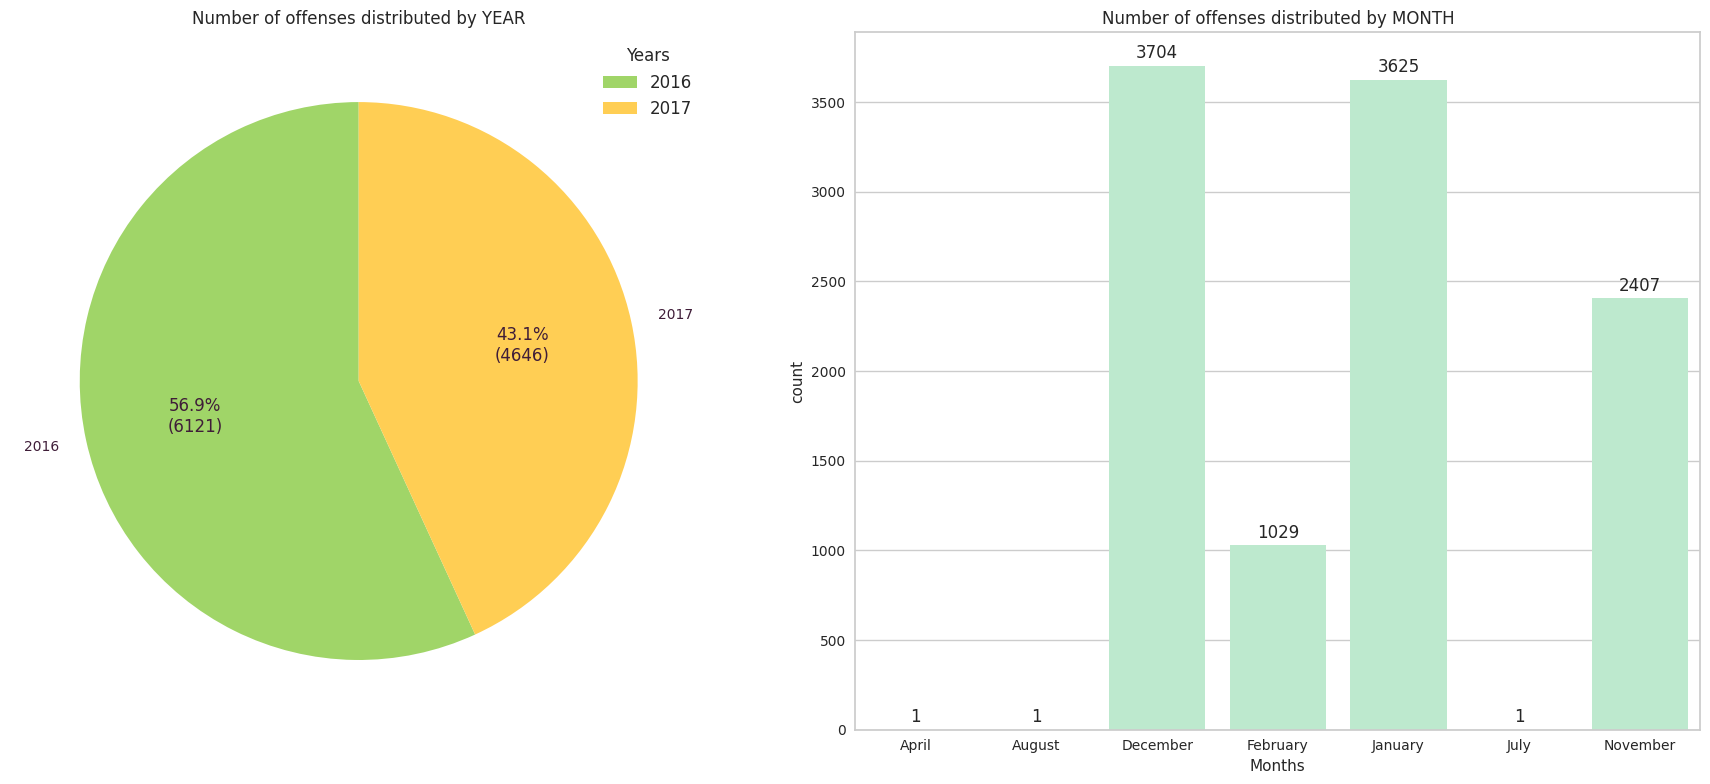

In [37]:
# Pie Chart

# Creating data
data = [len(df[df['INCIDENT_YEAR'] == feature]) for feature in df['INCIDENT_YEAR'].value_counts().index[0:2]]
labels = df['INCIDENT_YEAR'].value_counts().index[0:2]

colors = ['#A0D568', '#FFCE54'] # creating color parameters

# Creating autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

# Creating plot
plt.figure(figsize=(18, 8))
plt.rcParams.update({'font.size': 12})
plt.subplot(1, 2, 1)
plt.pie(data, labels=labels, colors=colors, autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color ="#3F1D38"))

# Adding legend
plt.legend(labels, fontsize="12", title ="Years", loc ='best',)

plt.title("Number of offenses distributed by YEAR")

# Bat chart
color=['#B5F1CC']
plt.subplot(1, 2, 2)
order = df['INCIDENT_MONTH'].value_counts().sort_index().index
ax = sns.countplot(x='INCIDENT_MONTH', data=df, order=order, palette=color)
for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    
plt.title('Number of offenses distributed by MONTH')
plt.xlabel('Months')

plt.tight_layout() 
plt.savefig('year_month.png')
plt.show()

### Number of offenses distributed by DATES, WEEKDAYS and TIME

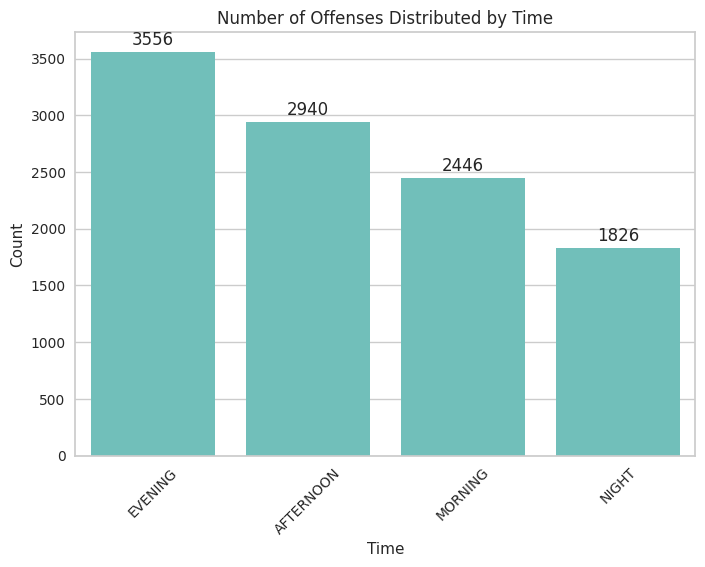

In [38]:
# Plot the count of offenses by time
order = df['INCIDENT_TIME'].value_counts().index
ax = sns.countplot(x='INCIDENT_TIME', data=df, color='#64CCC5', order=order)

for label in ax.containers[0]:
    ax.annotate(format(int(label.get_height())), 
                (label.get_x() + label.get_width() / 2., label.get_height()), 
                ha='center', va='center', xytext=(0, 9), textcoords='offset points')

plt.title('Number of Offenses Distributed by Time')
plt.xlabel('Time')
plt.ylabel('Count')

plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# plt.savefig('weekday_time.png')
plt.show()

### Number of offenses distributed by INCIDENT_REASON

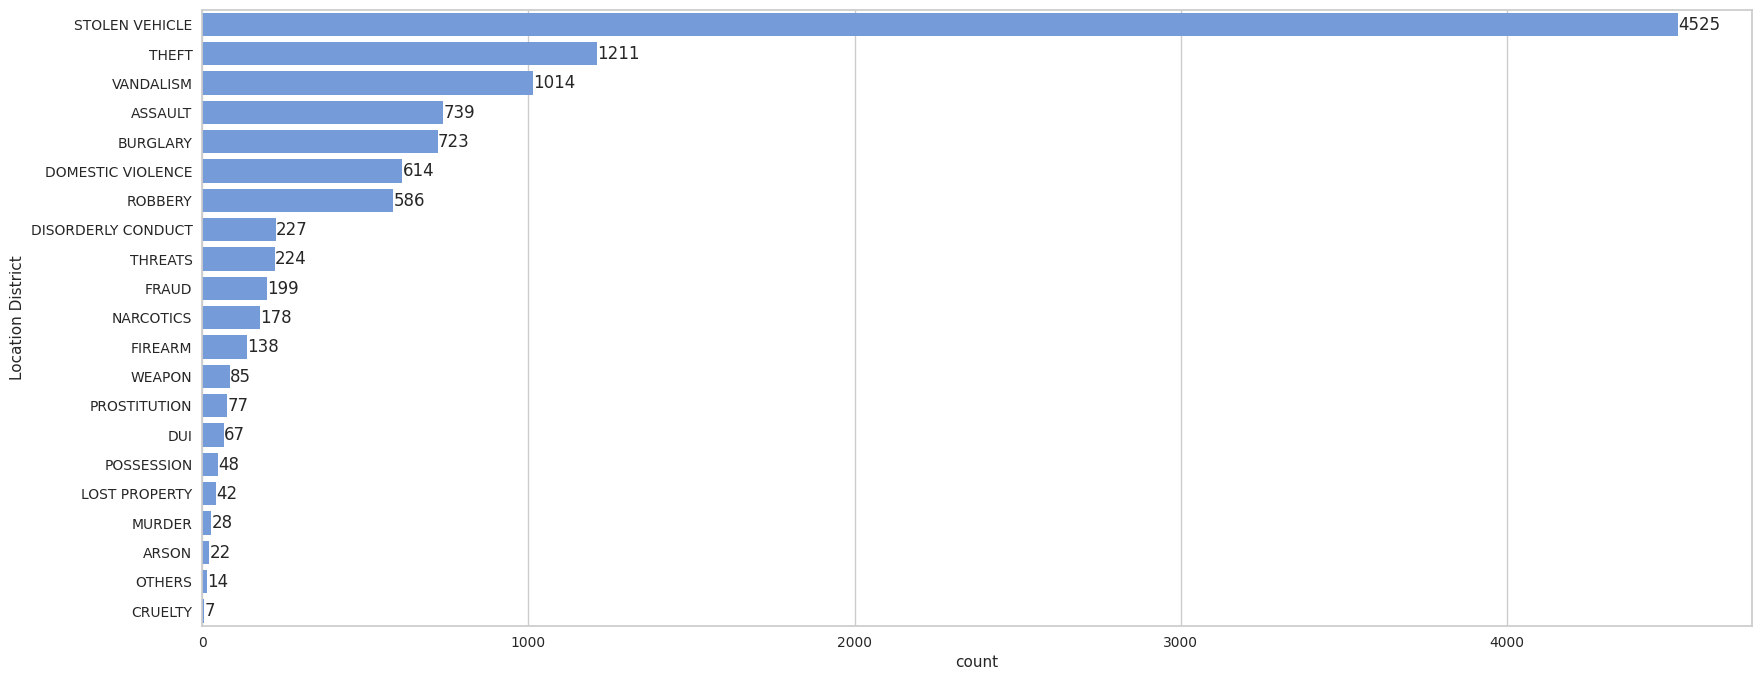

In [39]:
plt.figure(figsize=(20, 8))
order = df['INCIDENT_REASON'].value_counts().index
ax = sns.countplot(y=df['INCIDENT_REASON'], order=order, color='#6499E9')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('Location District')

# plt.savefig('INCIDENT_REASON.png')
plt.show()

### Number of offenses distributed by Location District

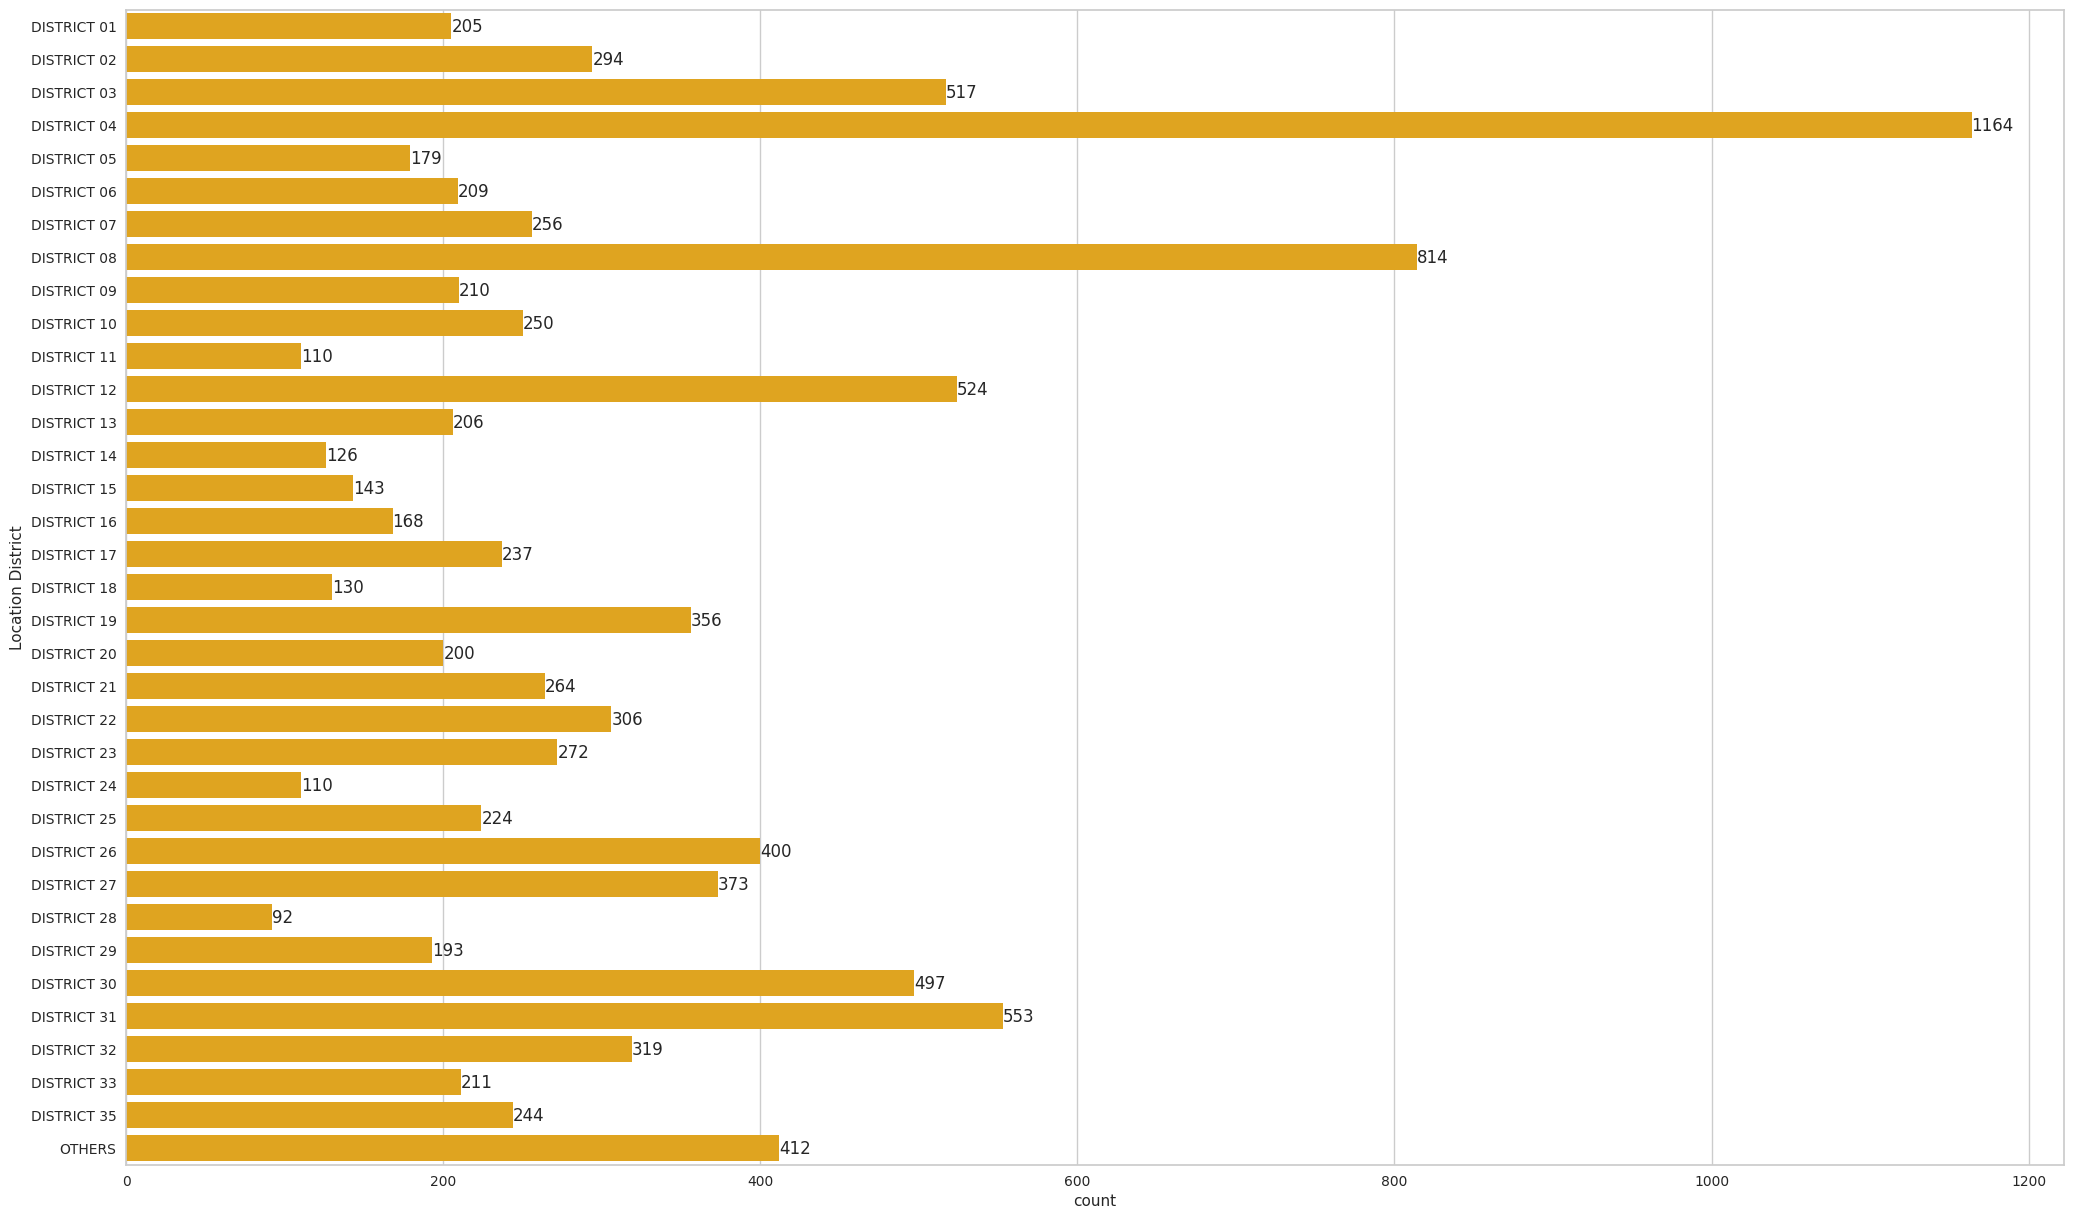

In [40]:
# Bar chart: Location district
plt.figure(figsize=(25, 15))
order = df['LOCATION_DISTRICT'].value_counts().sort_index().index
ax = sns.countplot(y=df['LOCATION_DISTRICT'], order=order, color='#FFB000')

for label in ax.containers:
    ax.bar_label(label)

plt.ylabel('Location District')

# plt.savefig('LOCATION_DISTRICT.png')
plt.show()

In [41]:
df['INCIDENT_YEAR'] = df['INCIDENT_YEAR'].astype(str)

# Step 3: Dimensionality Reduction

In [42]:
mca = MCA(n_components=515, n_iter=3, copy=True, check_input=True, random_state=42, one_hot=True)
mca = mca.fit(label_df)

In [43]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.364,0.37%,0.37%
1,0.321,0.33%,0.70%
2,0.313,0.32%,1.03%
3,0.306,0.31%,1.34%
4,0.301,0.31%,1.65%
...,...,...,...
510,0.134,0.14%,91.56%
511,0.131,0.14%,91.69%
512,0.130,0.13%,91.82%


In [44]:
features = mca.column_contributions_.sum(axis=1).sort_values(ascending=False)[:515].keys()

In [45]:
selected_features = []

for feature in features:
    for i in range(len(df.columns)):
        if df.columns[i] in feature:
            selected_features.append(df.columns[i])
            
selected_features = list(set(selected_features))
selected_features

['LOCATION_STREET_ADDRESS', 'INCIDENT_REASON', 'INCIDENT_MONTH']

In [46]:
mca_coordinates = mca.transform(label_df)
mca_coordinates

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,512,513,514
0,-0.427593,0.067613,0.436086,0.000554,0.130473,-0.062945,-0.188561,0.404694,-0.312041,-0.269160,...,0.394902,-0.128787,-0.118243,-0.533308,0.107389,-0.080387,0.131461,-0.075837,0.598487,0.177712
1,-0.710299,-0.436959,-0.110018,-0.201249,-0.392096,0.041722,0.651143,0.906498,1.022299,-0.083192,...,0.138822,0.188419,0.453182,0.079028,0.277799,-0.062541,0.196113,0.063078,-0.009122,0.164741
2,-0.303421,0.915652,-0.077452,0.129956,-0.349694,-0.325215,0.178776,-0.121548,0.210833,0.037275,...,-0.228401,0.403078,0.428784,0.013808,0.026737,-0.649597,-0.432116,-0.342860,0.215080,0.778864
3,-0.424310,-0.102816,1.055152,0.415355,1.342953,0.181632,0.200935,0.110320,0.118836,0.493162,...,-0.307463,0.091415,-0.030218,-0.141239,0.018751,-0.293275,-0.295317,0.113599,-0.113563,-0.395513
4,-0.628991,0.170906,0.509891,0.268438,0.166243,0.078683,-0.071938,0.358508,-0.203277,-0.162909,...,0.225332,0.133800,0.780300,0.353348,-0.288666,-0.579190,-0.415552,-0.517841,0.308213,0.661062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10764,0.694440,0.190704,0.447548,0.237986,-0.055926,0.008026,-0.090887,0.329426,-0.268239,-0.252632,...,0.424551,0.099342,-0.003013,-0.358531,-0.280020,-0.005928,0.166454,-0.267389,0.087967,-0.112210
10765,-0.052298,0.532768,-0.013713,-0.122037,0.145730,0.082990,0.113664,0.122011,-0.324715,-0.185177,...,0.142428,0.174535,0.109663,0.042508,0.136745,0.304277,0.112323,-0.306773,0.242253,0.245088
10766,0.441862,-0.442960,0.126400,0.092788,-0.431356,0.085316,-0.023187,0.008982,-0.243377,0.279944,...,-0.185495,0.067069,-0.389721,0.411019,0.745027,0.421261,0.351897,0.389007,-0.246943,-0.499548
10767,0.727282,-0.480010,0.993863,0.548663,1.695591,0.182427,0.378807,-0.027035,0.241798,0.274910,...,-0.125466,0.413899,-0.416767,0.371563,-0.260826,-0.468423,0.300992,-0.108731,0.044888,-0.171457


In [47]:
reduced_df = pd.DataFrame(label_df[selected_features], columns=selected_features)

In [48]:
reduced_df.head()

,LOCATION_STREET_ADDRESS,INCIDENT_REASON,INCIDENT_MONTH
0,279,18,2
1,193,16,2
2,437,4,2
3,336,11,2
4,387,4,2


# Step 4: Clustering

### Choosing the Number of Clusters k

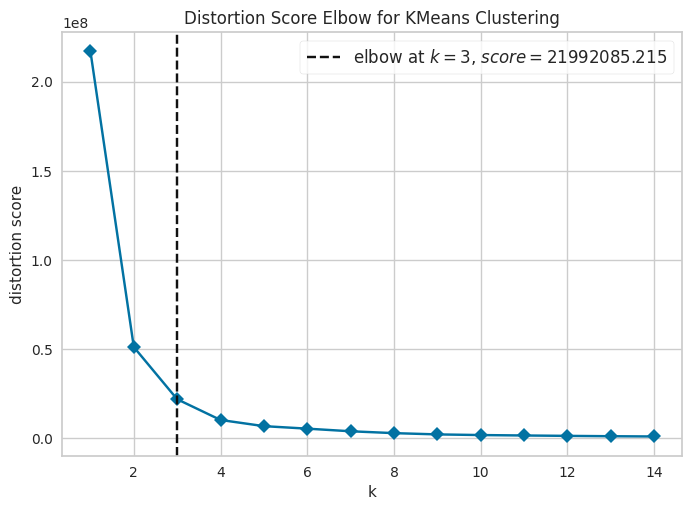

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [49]:
# create a k-Means model an Elbow-Visualizer
model = KMeans(init="k-means++", max_iter=200)
visualizer = KElbowVisualizer(model, k=(1, 15), timings=False)
 
# fit the visualizer and show the plot
visualizer.fit(reduced_df)
visualizer.show()

### K-Means clustering

In [50]:
# clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=100).fit(reduced_df)
 
# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_

# extract cluster labels
labels = kmeans.labels_ 

In [51]:
# creating dataframe for reduced data 
reduced_df['CLUSTERS'] = labels
reduced_df['CLUSTERS'] = reduced_df['CLUSTERS'].astype(str)
reduced_df.head()

,LOCATION_STREET_ADDRESS,INCIDENT_REASON,INCIDENT_MONTH,CLUSTERS
0,279,18,2,4
1,193,16,2,0
2,437,4,2,1
3,336,11,2,2
4,387,4,2,2


# Step 5: Cluster Analysis

In [52]:
# Analyzing cluster characteristics
cluster_characteristics = []
for i in range(n_clusters):    
    cluster_data = label_df[selected_features][labels == i]
    cluster_size = len(cluster_data)    
    cluster_center = centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))    
    cluster_characteristics.append({
        "Cluster": i,        
        "Size": cluster_size,
        "Avg Distance": avg_distance,    
    })
    
cluster_characteristics

[{'Cluster': 0, 'Size': 1286, 'Avg Distance': 22.475894622150182},
 {'Cluster': 1, 'Size': 3676, 'Avg Distance': 13.334573408043608},
 {'Cluster': 2, 'Size': 2688, 'Avg Distance': 17.059729981704912},
 {'Cluster': 3, 'Size': 1214, 'Avg Distance': 25.850477139364408},
 {'Cluster': 4, 'Size': 1306, 'Avg Distance': 26.32635171139016},
 {'Cluster': 5, 'Size': 598, 'Avg Distance': 13.432935796300157}]

In [53]:
# Calculate mean and median for each cluster
cluster_means = reduced_df.groupby('CLUSTERS').mean()
cluster_medians = reduced_df.groupby('CLUSTERS').median()

# Print the results
print("Cluster Means:")
print(cluster_means)

print("\nCluster Medians:")
print(cluster_medians)

Cluster Means:
          LOCATION_STREET_ADDRESS  INCIDENT_REASON  INCIDENT_MONTH
CLUSTERS                                                          
0                      155.283048        12.968896        3.685848
1                      445.107454        13.114527        3.686072
2                      340.284226        13.148810        3.594866
3                       46.551895        12.808896        3.748764
4                      240.668453        12.734303        3.657734
5                      498.595318        13.366221        3.615385

Cluster Medians:
          LOCATION_STREET_ADDRESS  INCIDENT_REASON  INCIDENT_MONTH
CLUSTERS                                                          
0                           151.0             16.0             4.0
1                           443.0             16.0             4.0
2                           336.0             16.0             4.0
3                            45.0             16.0             4.0
4                           2

In [54]:
# Print the cluster centroids
print("Cluster Centroids:")
print(centers)

Cluster Centroids:
[[155.28304821  12.9688958    3.68584759]
 [445.10745375  13.11452666   3.68607182]
 [340.28422619  13.14880952   3.59486607]
 [ 46.55189456  12.80889621   3.74876442]
 [240.66845329  12.73430322   3.65773354]
 [498.59531773  13.36622074   3.61538462]]


### Silhouette Score & Davies-Bouldin Index & Variance Ratio Criterion & Within-Cluster Sum of Squares (WCSS)

In [55]:
silhouette_avg = silhouette_score(label_df[selected_features], kmeans.labels_)
print('Silhouette Score', silhouette_avg)

db_index = davies_bouldin_score(label_df[selected_features], kmeans.labels_)
print('Davies-Bouldin Index:', db_index)

ch_score = calinski_harabasz_score(label_df[selected_features], kmeans.labels_)
print('Calinski-Harabasz Index (Variance Ratio Criterion):', ch_score)

wcss = kmeans.inertia_
print('Within-Cluster Sum of Squares (WCSS):', wcss)

Silhouette Score 0.6187823591264894
Davies-Bouldin Index: 0.5039929444659211
Calinski-Harabasz Index (Variance Ratio Criterion): 83351.33017849961
Within-Cluster Sum of Squares (WCSS): 5462619.933265427


# Step 6: Visualization of Clusters

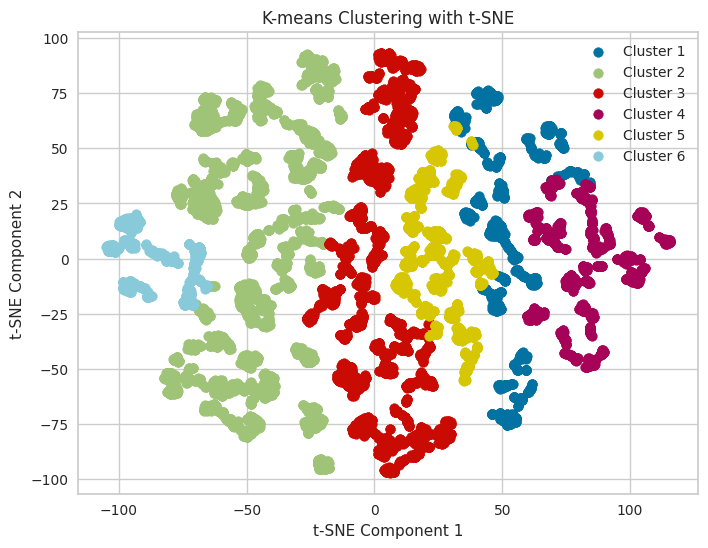

In [56]:
# Visualization of kmeans with TSNE

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(label_df)

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(projections[labels == i][:, 0], 
                projections[labels == i][:, 1], label=f'Cluster {i + 1}')
    
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering with t-SNE')
plt.legend(loc ='best')
plt.show()

In [57]:
# data = [len(reduced_df[reduced_df['CLUSTERS'] == feature]) for feature in reduced_df['CLUSTERS'].value_counts().index]
# labels = ['CLUSTER 1', 'CLUSTER 2', 'CLUSTER 3', 'CLUSTER 4']

# colors = ['#BEADFA', '#FFF3DA', '#96B6C5', '#C8E4B2']
# explode = (0.01, 0.01, 0.01, 0.01)

# # Creating autocpt arguments
# def func(pct, allvalues):
#     absolute = int(pct / 100. * np.sum(allvalues))
#     return "{:.1f}%\n({:d})".format(pct, absolute)

# # Creating the pie chart
# plt.figure(figsize=(20, 8))
# plt.pie(data, labels=labels, explode=explode, colors=colors, 
#         autopct=lambda pct: func(pct, data), startangle=90, textprops=dict(color="#3F1D38"))

# plt.legend(labels, title='Clusters')
# plt.title('Cluster Visualization')
# plt.show()

In [58]:
df['CLUSTERS'] = reduced_df['CLUSTERS']

In [59]:
def cluster_profile(df):
    profiles = {}
    
    for column in df.columns:
        if column != 'CLUSTERS':
            profiles[f'{column}'] = df[column].value_counts().keys()[0]
    
    return profiles

In [60]:
cluster_profile = df.groupby('CLUSTERS').apply(cluster_profile)
cluster_profile_df = pd.DataFrame(cluster_profile.tolist(), index=cluster_profile.index)

In [61]:
cluster_profile_df

,INCIDENT_REASON,LOCATION_DISTRICT,INCIDENT_YEAR,INCIDENT_MONTH,INCIDENT_TIME,LOCATION_STREET_ADDRESS
CLUSTERS,,,,,,
0,STOLEN VEHICLE,DISTRICT 31,2016,December,EVENING,FOOTHILL BLVD
1,STOLEN VEHICLE,DISTRICT 04,2016,December,EVENING,TH ST
2,STOLEN VEHICLE,DISTRICT 08,2016,January,EVENING,OTHERS
3,STOLEN VEHICLE,DISTRICT 04,2016,January,EVENING,BROADWAY
4,STOLEN VEHICLE,DISTRICT 04,2016,December,AFTERNOON,INTERNATIONAL BLVD
5,STOLEN VEHICLE,DISTRICT 08,2016,December,EVENING,WEBSTER ST
